Maximum pixel value: 1404.0


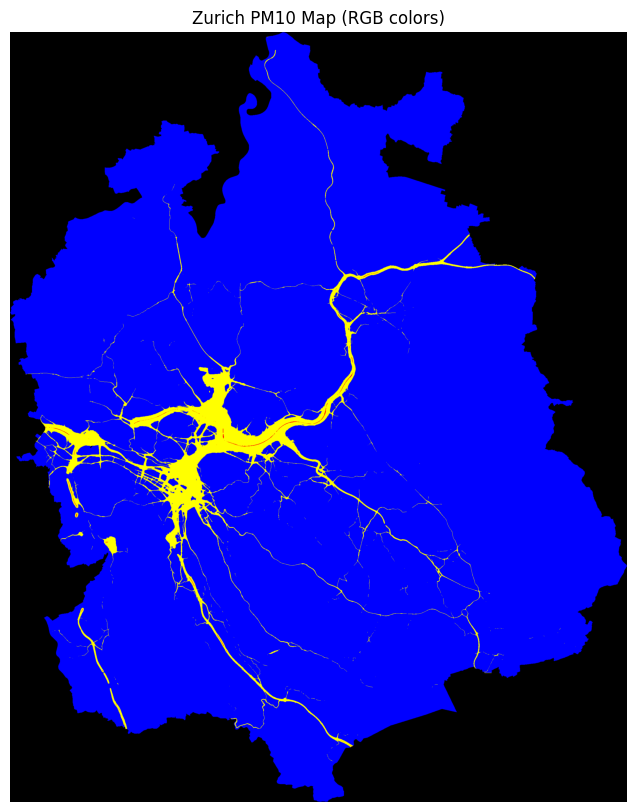

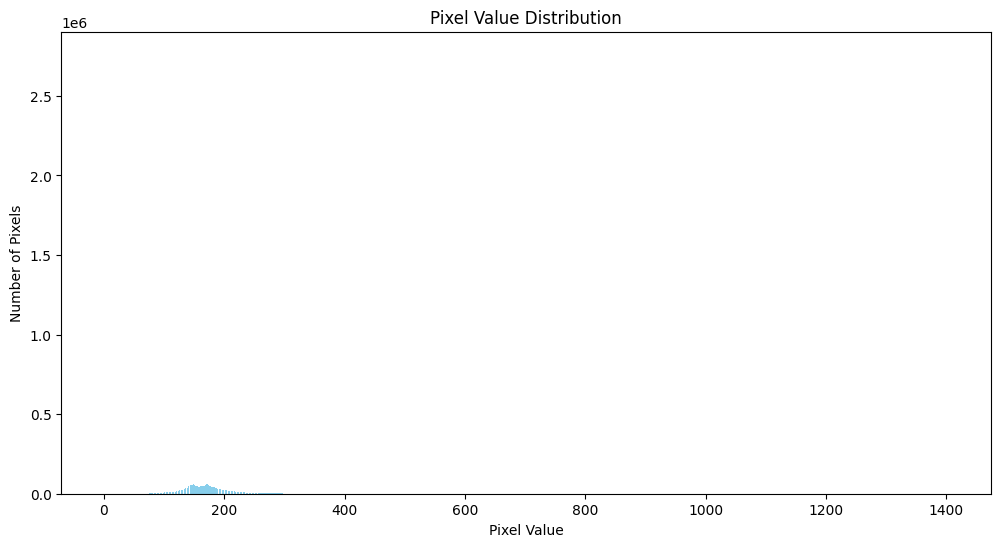

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/no2.tif"

with rasterio.open(input_file) as src:
    data = src.read(1).astype(float)  # convert to float to avoid overflow

# --- CREATE AN RGB IMAGE ---
# Initialize an empty array with 3 channels (height x width x 3)
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Apply the color rules
result[data < 1] = [0,0,0]
result[(data >= 1) & (data <= 255)] = [0, 0, 255]               # Blue
result[(data >= 255) & (data <= 750)] = [255, 255, 0]  # Yellow
result[data > 750] = [255, 0, 0]                  # Red

max_value = data.max()
print(f"Maximum pixel value: {max_value}")
# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Map (RGB colors)")
plt.axis("off")
plt.show()

values, counts = np.unique(data, return_counts=True)

# --- PLOT THE PIXEL VALUE DISTRIBUTION ---
plt.figure(figsize=(12, 6))
plt.bar(values, counts, color='skyblue')
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Number of Pixels")
plt.show()

Min value: 0
Max value: 255
Mean value: 193.25


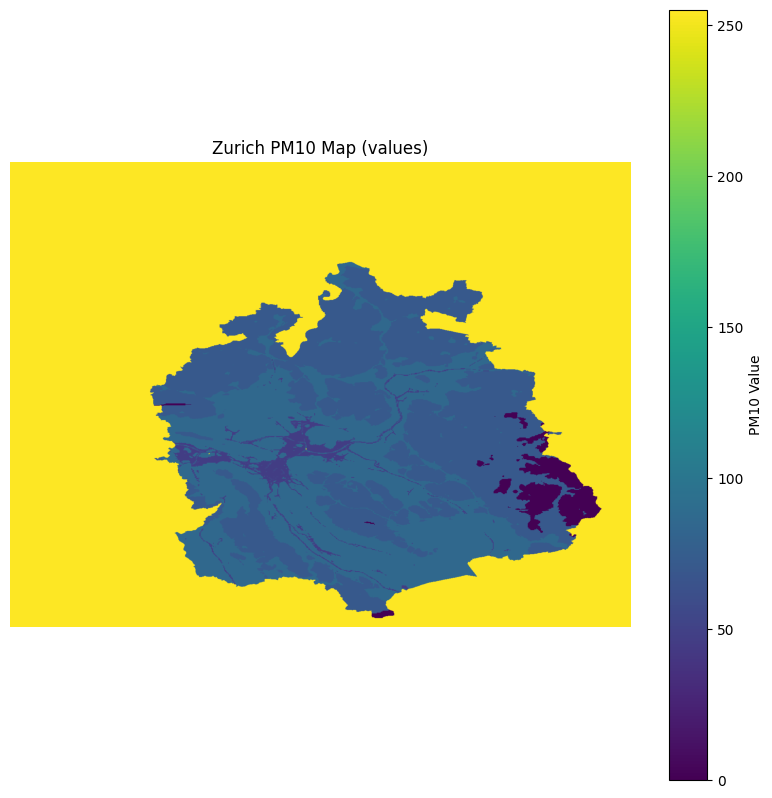

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/zurich_pm10_raw.tif"

with rasterio.open(input_file) as src:
    data = src.read(1)  # Read the first band

# --- EXAMINE THE VALUES ---
print(f"Min value: {np.min(data)}")
print(f"Max value: {np.max(data)}")
print(f"Mean value: {np.mean(data):.2f}")

# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(data, cmap="viridis")  # Use a continuous colormap
plt.colorbar(label="PM10 Value")
plt.title("Zurich PM10 Map (values)")
plt.axis("off")
plt.show()


Maximum pixel value: 351.0


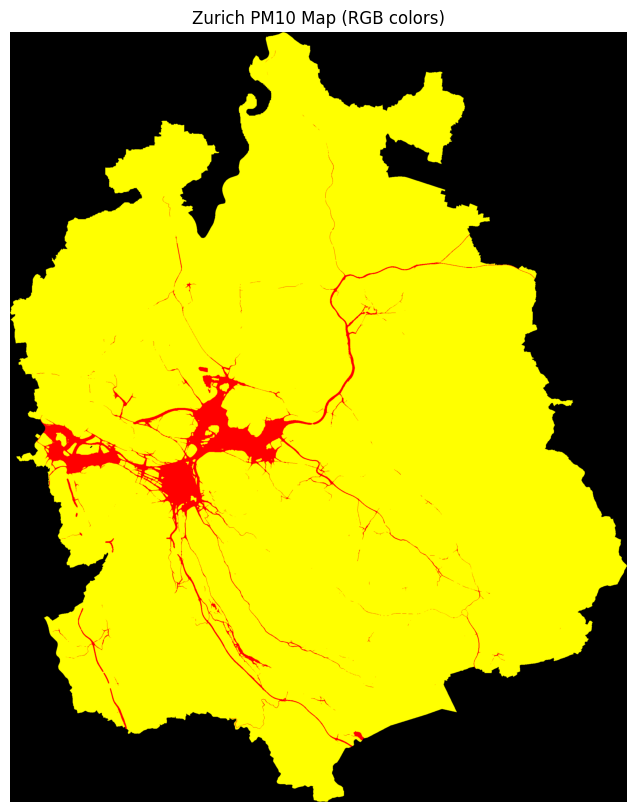

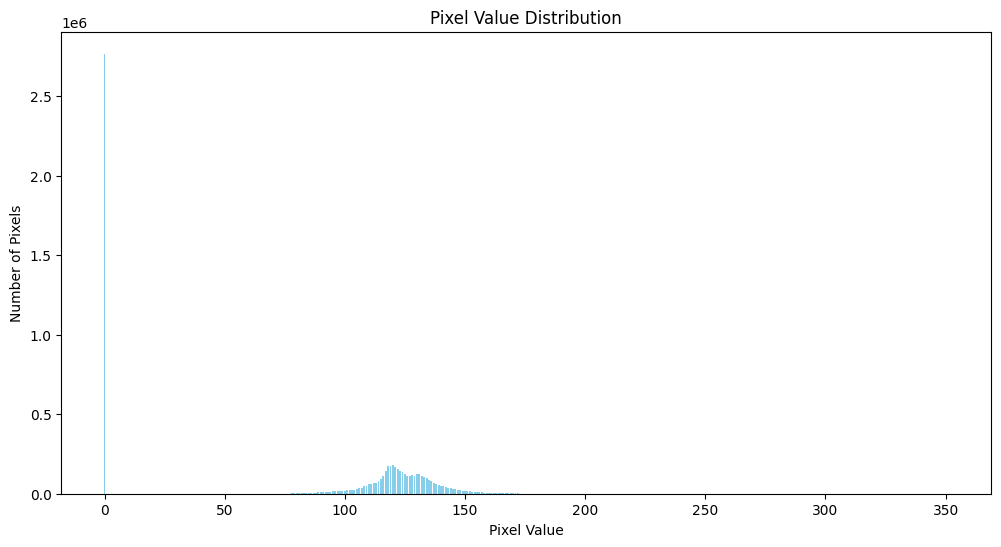

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/test.tif"

with rasterio.open(input_file) as src:
    data = src.read(1).astype(float)  # convert to float to avoid overflow

# --- CREATE AN RGB IMAGE ---
# Initialize an empty array with 3 channels (height x width x 3)
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Apply the color rules
result[data < 1] = [0,0,0]
result[(data >= 1) & (data <= 50)] = [0, 0, 255]               # Blue
result[(data >= 50) & (data <= 150)] = [255, 255, 0]  # Yellow
result[data > 150] = [255, 0, 0]                  # Red

max_value = data.max()
print(f"Maximum pixel value: {max_value}")
# --- DISPLAY USING MATPLOTLIB ---
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Map (RGB colors)")
plt.axis("off")
plt.show()

values, counts = np.unique(data, return_counts=True)

# --- PLOT THE PIXEL VALUE DISTRIBUTION ---
plt.figure(figsize=(12, 6))
plt.bar(values, counts, color='skyblue')
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Number of Pixels")
plt.show()

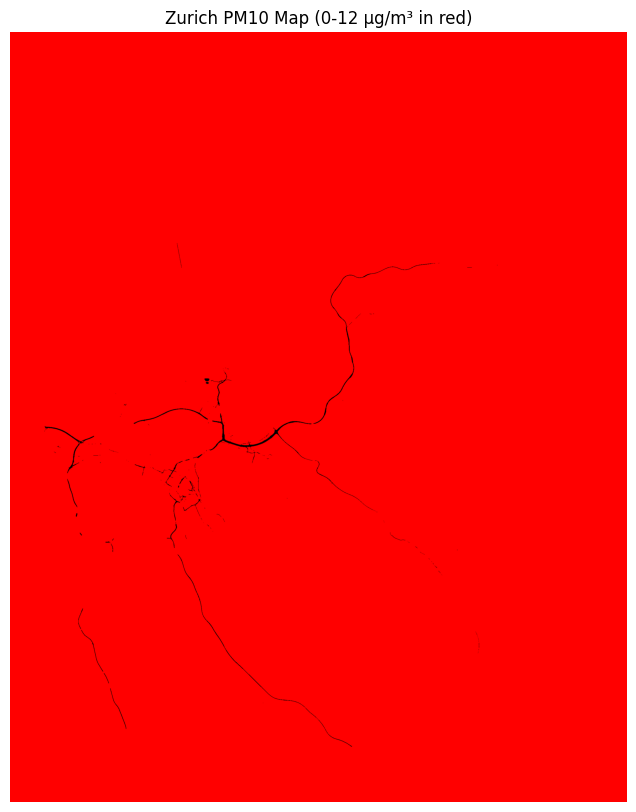

In [25]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the TIFF
with rasterio.open("../geoserver_data/data/test.tif") as src:
    data = src.read(1)  # read first band

# Create a mask for PM10 between 0 and 12
mask = (data >= 0) & (data <= 180)

# Prepare an RGB image: start with all black
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)

# Assign a color (e.g., red) to pixels in the range
result[mask] = [255, 0, 0]  # Red color, you can change to any RGB

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("Zurich PM10 Map (0-12 µg/m³ in red)")
plt.axis("off")
plt.show()


Downloaded and saved to pm10_2020_raw.tif
Raster size: (2048, 2048)
Raster data type: uint8
Number of pixels between 0‑12 µg/m³: 135449


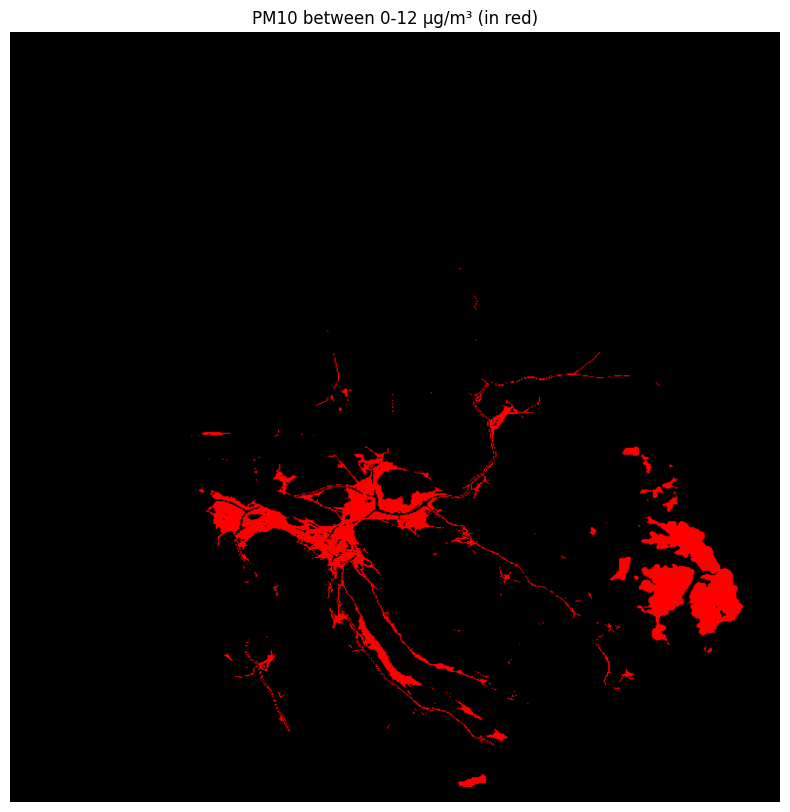

In [21]:
import requests
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the GetMap URL (raw TIFF)
url = (
    "https://wms.zh.ch/AwelLHPM10JahreZHWMS?"
    "SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&"
    "LAYERS=pm10-jahre-2020&STYLES=&"         # Empty STYLES to try get raw values
    "CRS=EPSG:2056&"
    "BBOX=2654500,1222400,2720000,1300000&"
    "WIDTH=2048&HEIGHT=2048&"                # higher resolution for better data
    "FORMAT=image/tiff"
)

# 2. Download the TIFF
print("Downloading TIFF from WMS …")
r = requests.get(url, stream=True)
r.raise_for_status()
fname = "pm10_2020_raw.tif"
with open(fname, "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)
print(f"Downloaded and saved to {fname}")

# 3. Read the TIFF and filter the values
with rasterio.open(fname) as src:
    data = src.read(1)        # read first band
    print("Raster size:", data.shape)
    print("Raster data type:", data.dtype)
    mask = (data >= 0) & (data <= 50)    # pixel value filter
    filtered_values = data[mask]
    print("Number of pixels between 0‑12 µg/m³:", filtered_values.size)

# 4. (Optional) Visualise the filtered pixels
result = np.zeros((data.shape[0], data.shape[1], 3), dtype=np.uint8)
result[mask] = [255, 0, 0]   # red for those pixels
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title("PM10 between 0‑12 µg/m³ (in red)")
plt.axis("off")
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# --- CONFIGURATION FOR FUZZY VARIABLES ---
# Format: input_file, max_value, variable_name, [good_range], [moderate_range], [bad_range]
fuzzy_inputs = [
    {
        "input_file": "../geoserver_data/data/pm25.tif",
        "max_value": 250,
        "name": "pm25",
        "good": [0, 0, 80],
        "moderate": [80, 160, 235],
        "bad": [235, 240, 250]
    }
]

# --- LOAD RASTERS ---
rasters = {}
meta = None

for var in fuzzy_inputs:
    with rasterio.open(var["input_file"]) as src:
        data = src.read(1).astype(float)
        rasters[var["name"]] = data
        if meta is None:
            meta = src.meta.copy()  # preserve geospatial info

# --- CREATE FUZZY VARIABLES ---
antecedents = {}

for var in fuzzy_inputs:
    ant = ctrl.Antecedent(np.linspace(0, var["max_value"], var["max_value"] + 1), var["name"])
    ant['good'] = fuzz.trimf(ant.universe, var['good'])
    ant['moderate'] = fuzz.trimf(ant.universe, var['moderate'])
    ant['bad'] = fuzz.trimf(ant.universe, var['bad'])
    antecedents[var['name']] = ant

# --- CONSEQUENT ---
quality = ctrl.Consequent(np.linspace(0, 100, 101), 'quality')
quality['very_good'] = fuzz.trimf(quality.universe, [0, 0, 25])
quality['good'] = fuzz.trimf(quality.universe, [20, 40, 60])
quality['liveable'] = fuzz.trimf(quality.universe, [50, 60, 70])
quality['bad'] = fuzz.trimf(quality.universe, [65, 80, 90])
quality['very_bad'] = fuzz.trimf(quality.universe, [85, 100, 100])

# --- DEFINE RULES ---
rules = [
    ctrl.Rule(antecedents['pm25']['good'], quality['very_good']),
    ctrl.Rule(antecedents['pm25']['moderate'], quality['liveable']),
    ctrl.Rule(antecedents['pm25']['bad'], quality['very_bad']),
]

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# --- APPLY FUZZY SYSTEM PIXEL-WISE ---
fuzzy_map = np.zeros_like(next(iter(rasters.values())), dtype=float)

# Flatten data for faster computation
flat_data = {}
for var in fuzzy_inputs:
    flat_data[var["name"]] = rasters[var["name"]].flatten()
    flat_result = np.zeros_like(flat_data[var["name"]], dtype=float)

first_key = next(iter(flat_data))
flat_result = np.zeros_like(flat_data[first_key], dtype=float)

Min: 0.0
Max: 204.0
Unique nodata-like values: []
Values above max_value: 0
NaNs: 0


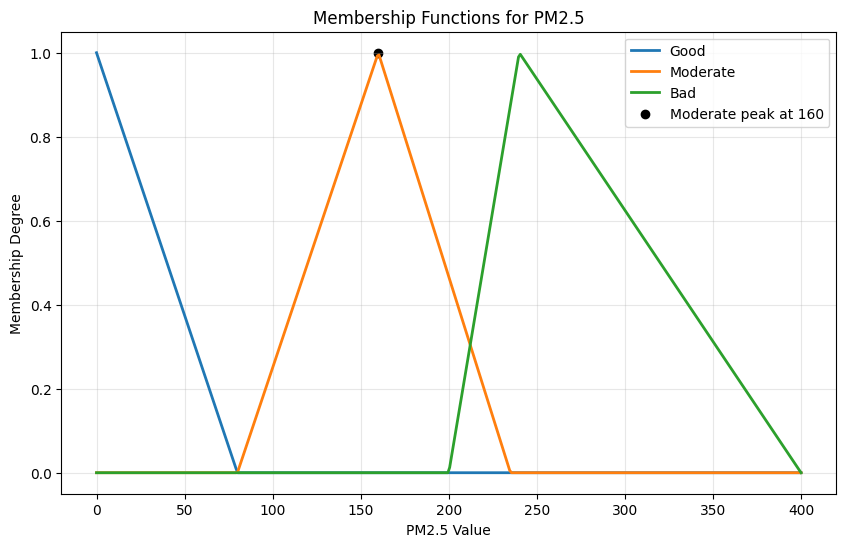

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

# Your definitions
good = [0, 0, 80]
moderate = [80, 160, 235]
bad = [200, 240, 400]

# Universe
x = np.linspace(0, 400, 400)

# Compute membership values
mf_good = fuzz.trimf(x, good)
mf_mod  = fuzz.trimf(x, moderate)
mf_bad  = fuzz.trimf(x, bad)

plt.figure(figsize=(10, 6))
plt.plot(x, mf_good, label='Good', linewidth=2)
plt.plot(x, mf_mod,  label='Moderate', linewidth=2)
plt.plot(x, mf_bad,  label='Bad', linewidth=2)

plt.scatter([160], [1], color="black", label="Moderate peak at 160")

plt.title("Membership Functions for PM2.5")
plt.xlabel("PM2.5 Value")
plt.ylabel("Membership Degree")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
